In [33]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk


In [34]:
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from textblob import TextBlob

In [35]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [36]:
# Create 'data' folder if it doesn't exist
if not os.path.exists("data"):
    os.makedirs("data")

In [37]:
# Function to scrape Skytrax airline reviews
def scrape_skytrax_reviews(airline_url, num_pages=5):
    reviews = []
    for page in range(1, num_pages + 1):
        url = f"{airline_url}/page/{page}/"
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Failed to retrieve page {page}")
            continue
        soup = BeautifulSoup(response.text, 'html.parser')
        review_blocks = soup.find_all('div', class_='body')
        for block in review_blocks:
            title = block.find('h2').text.strip() if block.find('h2') else ""
            text = block.find('div', class_='text').text.strip() if block.find('div', class_='text') else ""
            reviews.append([title, text])
    return pd.DataFrame(reviews, columns=['Title', 'Review'])

In [38]:
airline_url = "https://www.airlinequality.com/"
df = scrape_skytrax_reviews(airline_url)
df.to_csv("data/reviews.csv", index=False)

In [39]:
# Load data (if already scraped)
df = pd.read_csv("data/reviews.csv")

In [40]:
# Ensure stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yoges\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yoges\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [41]:
stop_words = set(stopwords.words('english'))

In [42]:
# Text Cleaning Function
def clean_text(text):
    if isinstance(text, str):  # Check if the value is a string
        text = text.lower()
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        return " ".join(tokens)
    return ""  # Return empty string for NaN values

# Apply cleaning function
df['Cleaned_Review'] = df['Review'].apply(clean_text)

In [43]:
# Sentiment Analysis
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['Sentiment'] = df['Cleaned_Review'].apply(get_sentiment)

df['Sentiment_Label'] = df['Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

In [45]:
# Visualization: Sentiment Distribution
text_data = " ".join(df['Cleaned_Review'].dropna().values)
if len(text_data.strip()) == 0:
    print("No valid words found for WordCloud.")
else:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig("data/wordcloud.png")
    plt.show()




No valid words found for WordCloud.


C:\Users\yoges\AppData\Local\Temp\ipykernel_17052\1603097513.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Sentiment_Label'], palette='coolwarm', order=['Positive', 'Neutral', 'Negative'])


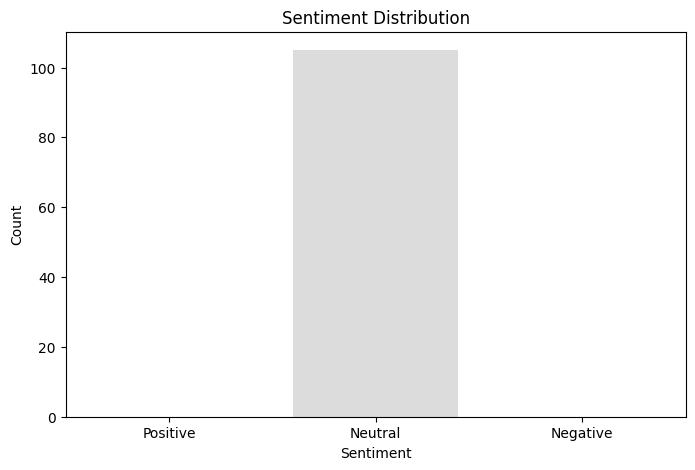

In [46]:
# Ensure there are no NaN values in Sentiment_Label
df['Sentiment_Label'] = df['Sentiment_Label'].fillna('Neutral')

# Visualization: Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df['Sentiment_Label'], palette='coolwarm', order=['Positive', 'Neutral', 'Negative'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.savefig("data/sentiment_distribution.png")
plt.show()


In [47]:
print(df[['Sentiment_Label', 'Cleaned_Review']].head())  # Quick check
print(df['Sentiment_Label'].value_counts())  # Count sentiment categories


  Sentiment_Label Cleaned_Review
0         Neutral               
1         Neutral               
2         Neutral               
3         Neutral               
4         Neutral               
Sentiment_Label
Neutral    105
Name: count, dtype: int64
